In [1]:
from GmGM.synthetic import DatasetGenerator, PrecMatGenerator, PrecMatErdosRenyiGilbert
from GmGM import GmGM
from TeraLasso import TeraLasso
from EiGLasso import EiGLasso

import timeit
from statistics import median
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_timing_data_smart(
    algorithms: dict[str, callable],
    sizes: list[int],
    K: int,
    attempts: int, 
    cutoff: int = 60,
    verbose: bool = False
):  
    includes: dict[str, bool] = {}
    times: dict[str, list[float]] = {}
    
    for algorithm in algorithms:
        includes[algorithm]: bool = True
        times[algorithm]: list[float] = []
    for d in sizes:
        if not any(includes.values()):
            if verbose:
                print("All algorithms timed out")
            break
        if verbose:
            print(f"Starting {(d,) * K}")

        # Generate Data
        structure = {
            "dataset_0": tuple(f"axis_{j}" for j in range(K))
        }
        sub_generators = {
            f"axis_{i}": PrecMatGenerator(
                core_type="coreless",
                mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            )
            for i in range(K)
        }
        generator = DatasetGenerator(
            structure=structure,
            generator=sub_generators,
            size={axis: d for axis in structure["dataset_0"]},
        )
        generator.reroll_Psis()
        dataset = generator.generate({"dataset_0": 1})

        # Test algorithms
        for algorithm in algorithms.keys():
            if not includes[algorithm]:
                continue
            times[algorithm].append(0)
            durations = timeit.Timer(
                lambda: algorithms[algorithm](dataset.deepcopy())
            ).repeat(
                repeat=attempts,
                number=1
            )
            times[algorithm][-1] = median(durations)
            if times[algorithm][-1] >= cutoff:
                if verbose:
                    print(f"{algorithm} ran for longer than {cutoff} seconds")
                    print(f"{algorithm} is no longer being tracked")
                includes[algorithm] = False
            else:
                if verbose:
                    print(f"\t{algorithm}: {times[algorithm][-1]} Seconds")
    print("Done")
    return times

## 2-Axis Runtimes

In [3]:
algorithms = {
    "GmGM": lambda dataset: GmGM(dataset, to_keep=10),
    "GmGM-50pc": lambda dataset: GmGM(dataset, to_keep=10, n_comps=50),
    "TeraLasso": lambda dataset: TeraLasso(dataset, 0),
    "EiGLasso": lambda dataset: EiGLasso(dataset, 0),
}
size_data = [
    100, 125, 150, 175, 200, 225, 250, 275,
    300, 400, 500, #600, 700, 800, 900, 1000,
    #1100, 1200, 1300, 1400, 1500, 1750, 2000, 2250, 2500,
    #3000, 3500, 4000,
]
timing_data = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data,
    K=2,
    attempts=5,
    verbose=True
)

Starting (100, 100)
	GmGM: 0.04771412500000061 Seconds
	GmGM-50pc: 0.3307995419999994 Seconds
	TeraLasso: 1.7486511659999984 Seconds
	EiGLasso: 7.841703750000001 Seconds
Starting (125, 125)
	GmGM: 0.046170582999998544 Seconds
	GmGM-50pc: 0.382374083000002 Seconds
	TeraLasso: 2.606593332999992 Seconds
	EiGLasso: 11.937980166999992 Seconds
Starting (150, 150)
	GmGM: 0.07054145899999753 Seconds
	GmGM-50pc: 0.2861272920000033 Seconds
	TeraLasso: 5.242469459000006 Seconds
	EiGLasso: 18.171419333000017 Seconds
Starting (175, 175)
	GmGM: 0.0896961669999996 Seconds
	GmGM-50pc: 0.4281484999999634 Seconds
	TeraLasso: 7.823068417000002 Seconds
	EiGLasso: 24.693680791999952 Seconds
Starting (200, 200)
	GmGM: 0.11681375000000571 Seconds
	GmGM-50pc: 0.31788612500002955 Seconds
	TeraLasso: 10.165696792000006 Seconds
	EiGLasso: 35.366938291999986 Seconds
Starting (225, 225)
	GmGM: 0.21511358400005065 Seconds
	GmGM-50pc: 0.642366749999951 Seconds
	TeraLasso: 14.322318083000027 Seconds
	EiGLasso: 44.149

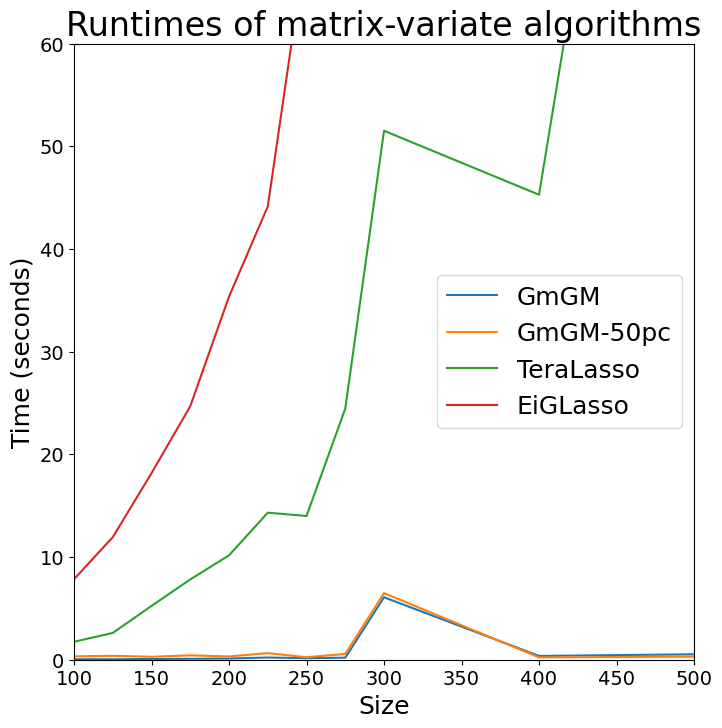

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data):
    ax.plot(
        size_data[:len(timing_data[algorithm])],
        timing_data[algorithm],
        label=algorithm,
        #linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of matrix-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data[0], size_data[-1]])
ax.legend(fontsize=18)

## 3-Axis Runtimes

In [5]:
algorithms = {
    "GmGM": lambda dataset: GmGM(dataset, to_keep=10),
    "GmGM-50pc": lambda dataset: GmGM(dataset, to_keep=10, n_comps=50),
    "TeraLasso": lambda dataset: TeraLasso(dataset, 0),
}
size_data = [
    50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,
    160, 170, 180, 190, 200, #250, 300, 350, 400,
]
timing_data = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data,
    K=3,
    attempts=5,
    verbose=True
)

Starting (50, 50, 50)
	GmGM: 0.3048469999998815 Seconds
	GmGM-50pc: 0.7838222499999574 Seconds
	TeraLasso: 0.6130896669997128 Seconds
Starting (60, 60, 60)
	GmGM: 0.44138058399994406 Seconds
	GmGM-50pc: 1.4657052079996902 Seconds
	TeraLasso: 0.7565767910000432 Seconds
Starting (70, 70, 70)
	GmGM: 0.5263128750002579 Seconds
	GmGM-50pc: 0.6122429580000244 Seconds
	TeraLasso: 1.5307511249998242 Seconds
Starting (80, 80, 80)
	GmGM: 0.8310695830000441 Seconds


KeyboardInterrupt: 

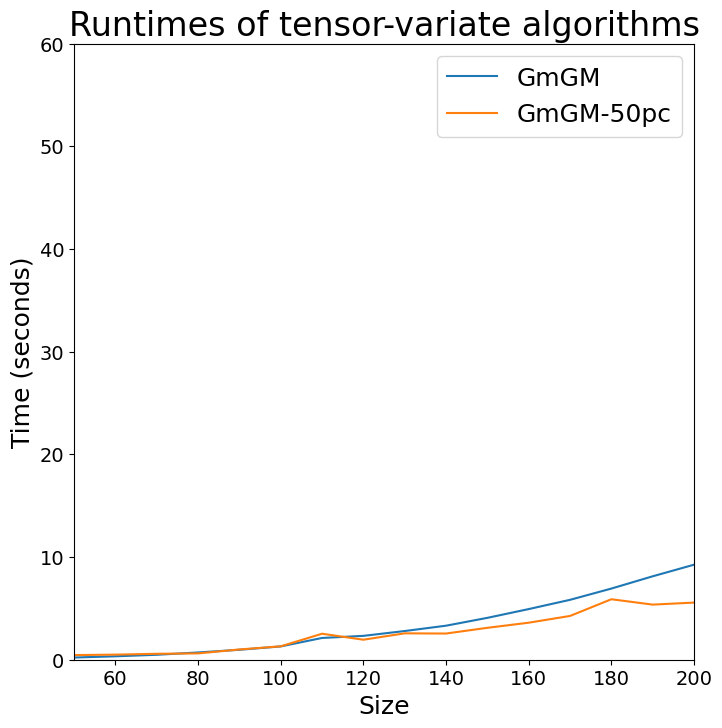

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data):
    ax.plot(
        size_data[:len(timing_data[algorithm])],
        timing_data[algorithm],
        label=algorithm,
        #linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of tensor-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data[0], size_data[-1]])
ax.legend(fontsize=18)

## 4-Axis Runtimes

In [ ]:
algorithms = {
    "GmGM": lambda dataset: GmGM(dataset, to_keep=10),
    "GmGM-50pc": lambda dataset: GmGM(dataset, to_keep=10, n_comps=50),
    "TeraLasso": lambda dataset: TeraLasso(dataset, 0),
}
size_data = [
    20, 30, 40, 50, #60, 70, 80, 90, 100
]
timing_data = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data,
    K=4,
    attempts=5,
    verbose=True
)

Starting (20, 20, 20, 20)
	GmGM: 0.21513325000000805 Seconds
	GmGM-50pc: 0.5452521249999336 Seconds
Starting (30, 30, 30, 30)
	GmGM: 0.7697213750000174 Seconds
	GmGM-50pc: 1.261505292000038 Seconds
Starting (40, 40, 40, 40)
	GmGM: 1.2548760829999992 Seconds
	GmGM-50pc: 2.700881957999968 Seconds
Starting (50, 50, 50, 50)
	GmGM: 0.8135792089999541 Seconds
	GmGM-50pc: 8.79878845799999 Seconds
Done


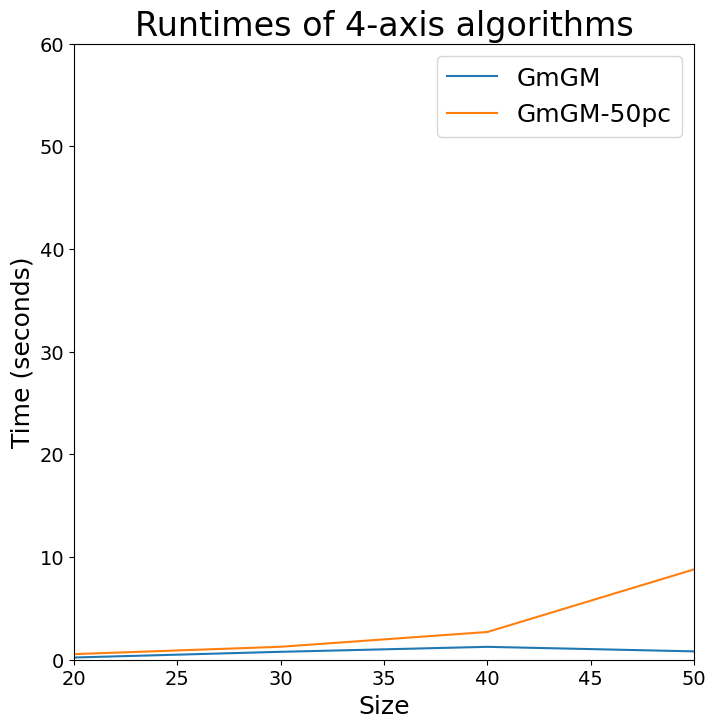

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data):
    ax.plot(
        size_data[:len(timing_data[algorithm])],
        timing_data[algorithm],
        label=algorithm,
        #linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 4-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data[0], size_data[-1]])
ax.legend(fontsize=18)